# 0X: Kanji meaning inference

In this tutorial, we walk through an example of loading a pretrained CTM and using it for inference. Specifically, we'll download a CTM trained on ImageNet, and use it for inference.

### Imports

In [19]:
import sys
sys.path.append("../../continuous-thought-machines_mine")

import torch
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
from models.ctm import ContinuousThoughtMachine as CTM
import urllib
from IPython.display import Image as IPyImage, display
from pprint import pprint
import numpy as np
import seaborn as sns
import os
import torch.nn.functional as F
from matplotlib import patheffects
from scipy import ndimage
import imageio
import mediapy
from tasks.image_classification.plotting import plot_neural_dynamics
from tasks.image_classification.imagenet_classes import IMAGENET2012_CLASSES
import json

from datetime import datetime
from utils.housekeeping import save_dict_to_csv, get_meaning, get_number, load_dict_from_csv

import glob

#### Plot loss

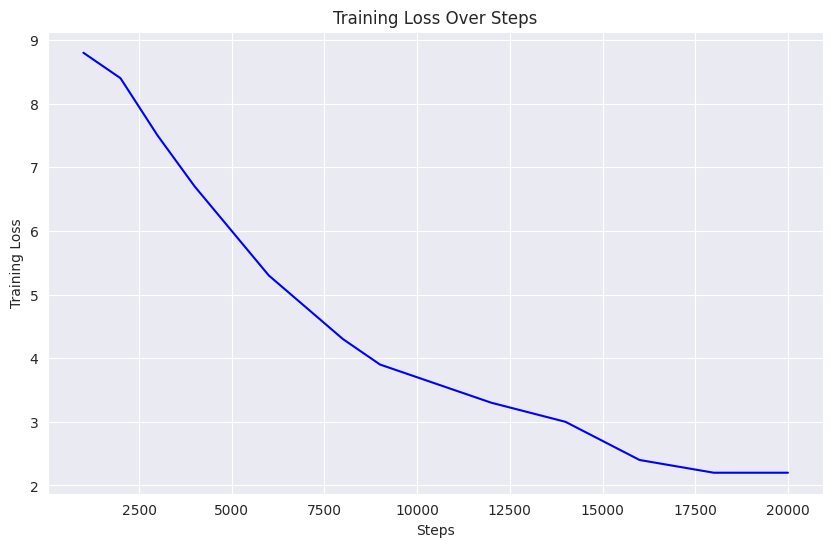

In [20]:
%matplotlib inline

file_path = "Kanji_test5_updDS1_heads4/loss_v2_till20000.csv"
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' was not found.")

df = pd.read_csv(file_path)

if 'steps' not in df.columns or 'train_loss' not in df.columns:
    print("Error: The CSV file must contain 'steps' and 'train_loss' columns.")

plt.figure(figsize=(10, 6))
plt.plot(df['steps'], df['train_loss'], marker='', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

#### Print image by meaning

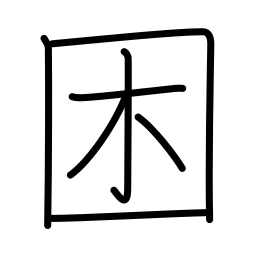

In [21]:
def get_image_by_prompt(folder_prefix, meaning):
    metadata_path = os.path.join(folder_prefix, 'metadata.jsonl')
    
    with open(metadata_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            if data['prompt'] == meaning:
                file_name = data['file_name']
                image_path = os.path.join(folder_prefix, file_name)
                image = Image.open(image_path).convert("RGB")
                display(image)
                return
    
    print(f"No image found for prompt: '{meaning}'")

prompt = "quandary"
get_image_by_prompt("Kanji/train", prompt)

### Functions

In [22]:
def get_kanji_meanings(file_name, metadata_file):
    meanings = []
    try:
        with open(metadata_file, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    entry = json.loads(line)
                    # Check if the file_name in the entry matches the one we're looking for
                    if entry.get('file_name') == file_name:
                        # Append the prompt to our list of meanings
                        meanings.append(entry.get('prompt'))
                except json.JSONDecodeError:
                    print(f"Warning: Skipping malformed JSON line in '{metadata_file}': {line.strip()}")
                    continue
    except FileNotFoundError:
        print(f"Error: The file '{metadata_file}' was not found. Please ensure it is in the correct directory.")
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []
    
    return meanings

##### Function to make GIFS

Next, we write a function to make pretty gifs.

In [23]:
def make_gif(predictions, certainties, attention_tracking, ground_truth_target, out_path, dataset_mean, dataset_std, class_labels, input_tensor, isGrayscale=False):
    if isGrayscale:
        first_dim = 1
    else:
        first_dim = 3

    def find_island_centers(array_2d, threshold):
        """
        Finds the center of mass of each island (connected component > threshold)
        in a 2D array, weighted by the array's values.
        Returns list of (y, x) centers and list of areas.
        """
        binary_image = array_2d > threshold
        labeled_image, num_labels = ndimage.label(binary_image)
        centers = []
        areas = []
        # Calculate center of mass for each labeled island (label 0 is background)
        for i in range(1, num_labels + 1):
            island_mask = (labeled_image == i)
            total_mass = np.sum(array_2d[island_mask])
            if total_mass > 0:
                # Get coordinates for this island
                y_coords, x_coords = np.mgrid[:array_2d.shape[0], :array_2d.shape[1]]
                # Calculate weighted average for center
                x_center = np.average(x_coords[island_mask], weights=array_2d[island_mask])
                y_center = np.average(y_coords[island_mask], weights=array_2d[island_mask])
                centers.append((round(y_center, 4), round(x_center, 4)))
                areas.append(np.sum(island_mask)) # Area is the count of pixels in the island
        return centers, areas

    interp_mode = 'nearest'
    figscale = 0.85

    # predictions: (B, Classes, Steps), attention_tracking: (Steps*B*Heads, SeqLen)
    n_steps = predictions.size(-1)

    # --- Reshape Attention ---
    # Infer feature map size from model internals (assuming B=1)
    h_feat, w_feat = model.kv_features.shape[-2:]

    n_heads = attention_tracking.shape[2] 
    # Reshape to (Steps, Heads, H_feat, W_feat) assuming B=1
    attention_tracking = attention_tracking.reshape(n_steps, n_heads, h_feat, w_feat)

    # --- Setup for Plotting ---
    step_linspace = np.linspace(0, 1, n_steps) # For step colors
    # Define color maps
    cmap_spectral = sns.color_palette("Spectral", as_cmap=True)
    cmap_attention = sns.color_palette('viridis', as_cmap=True)

    # Create output directory for this index
    index_output_dir = os.path.join(out_path, str(0))
    os.makedirs(index_output_dir, exist_ok=True)

    frames = [] # Store frames for GIF
    head_routes = {h: [] for h in range(n_heads)} # Store (y,x) path points per head
    head_routes[-1] = []
    route_colours_step = [] # Store colors for each step's path segments

    # --- Loop Through Each Step ---
    for step_i in range(n_steps):

        # --- Prepare Image for Display ---
        # Denormalize the input tensor for visualization
        data_img_tensor = input_tensor[0].cpu() # Get first item in batch, move to CPU
        mean_tensor = torch.tensor(dataset_mean).view(first_dim, 1, 1)
        std_tensor = torch.tensor(dataset_std).view(first_dim, 1, 1)
        data_img_denorm = data_img_tensor * std_tensor + mean_tensor
        # Permute to (H, W, C) and convert to numpy, clip to [0, 1]
        data_img_np = data_img_denorm.permute(1, 2, 0).detach().numpy()
        data_img_np = np.clip(data_img_np, 0, 1)
        img_h, img_w = data_img_np.shape[:2]

        # --- Process Attention & Certainty ---
        # Average attention over last few steps (from original code)
        start_step = max(0, step_i - 5)
        attention_now = attention_tracking[start_step : step_i + 1].mean(0) # Avg over steps -> (Heads, H_feat, W_feat)
        # Get certainties up to current step
        certainties_now = certainties[0, 1, :step_i+1].detach().cpu().numpy() # Assuming index 1 holds relevant certainty

        # --- Calculate Attention Paths (using bilinear interp) ---
        # Interpolate attention to image size using bilinear for center finding
        attention_interp_bilinear = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(), # Add batch dim, ensure float
            size=(img_h, img_w),
            mode=interp_mode,
            # align_corners=False
        ).squeeze(0) # Remove batch dim -> (Heads, H, W)

        # Normalize each head's map to [0, 1]
        # Deal with mean
        attn_mean = attention_interp_bilinear.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)
        centers, areas = find_island_centers(attn_mean.detach().cpu().numpy(), threshold=0.7)

        if centers: # If islands found
            largest_island_idx = np.argmax(areas)
            current_center = centers[largest_island_idx] # (y, x)
            head_routes[-1].append(current_center)
        elif head_routes[-1]: # If no center now, repeat last known center if history exists
            head_routes[-1].append(head_routes[-1][-1])


        attn_min = attention_interp_bilinear.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max = attention_interp_bilinear.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_bilinear = (attention_interp_bilinear - attn_min) / (attn_max - attn_min + 1e-6)

        # Store step color
        current_colour = list(cmap_spectral(step_linspace[step_i]))
        route_colours_step.append(current_colour)

        # Find island center for each head
        for head_i in range(n_heads):
            attn_head_np = attention_interp_bilinear[head_i].detach().cpu().numpy()
            # Keep threshold=0.7 based on original call
            centers, areas = find_island_centers(attn_head_np, threshold=0.7)

            if centers: # If islands found
                largest_island_idx = np.argmax(areas)
                current_center = centers[largest_island_idx] # (y, x)
                head_routes[head_i].append(current_center)
            elif head_routes[head_i]: # If no center now, repeat last known center if history exists
                    head_routes[head_i].append(head_routes[head_i][-1])
        
                

        # --- Plotting Setup ---
        mosaic = [['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                ['head_0', 'head_0_overlay', 'head_1', 'head_1_overlay', 'head_2', 'head_2_overlay', 'head_3', 'head_3_overlay'],
                ['head_4', 'head_4_overlay', 'head_5', 'head_5_overlay','head_6', 'head_6_overlay', 'head_7', 'head_7_overlay'],
                ['head_8', 'head_8_overlay', 'head_9', 'head_9_overlay','head_10', 'head_10_overlay', 'head_11', 'head_11_overlay'],
                ['head_12', 'head_12_overlay', 'head_13', 'head_13_overlay','head_14', 'head_14_overlay', 'head_15', 'head_15_overlay'],
                ['probabilities', 'probabilities','probabilities', 'probabilities', 'certainty', 'certainty', 'certainty', 'certainty'],
                ]

        img_aspect = data_img_np.shape[0] / data_img_np.shape[1]
        aspect_ratio = (8 * figscale, 9 * figscale * img_aspect) # W, H
        fig, axes = plt.subplot_mosaic(mosaic, figsize=aspect_ratio)

        for ax in axes.values():
            ax.axis('off')

        # --- Plot Certainty ---
        ax_cert = axes['certainty']
        ax_cert.plot(np.arange(len(certainties_now)), certainties_now, 'k-', linewidth=figscale*1)
        # Add background color based on prediction correctness at each step
        for ii in range(len(certainties_now)):
            is_correct = predictions[0, :, ii].argmax(-1).item() == ground_truth_target # .item() for scalar tensor
            facecolor = 'limegreen' if is_correct else 'orchid'
            ax_cert.axvspan(ii, ii + 1, facecolor=facecolor, edgecolor=None, lw=0, alpha=0.3)
        # Mark the last point
        ax_cert.plot(len(certainties_now)-1, certainties_now[-1], 'k.', markersize=figscale*4)
        ax_cert.axis('off')
        ax_cert.set_ylim([0.05, 1.05])
        ax_cert.set_xlim([0, n_steps]) # Use n_steps for consistent x-axis limit

        # --- Plot Probabilities ---
        ax_prob = axes['probabilities']
        # Get probabilities for the current step
        ps = torch.softmax(predictions[0, :, step_i], -1).detach().cpu()
        k = 5 # Top k predictions
        topk_probs, topk_indices = torch.topk(ps, k, dim=0, largest=True)
        topk_indices = topk_indices.numpy()
        topk_probs = topk_probs.numpy()

        true_class_idx = ground_truth_target # Ground truth index

        # Determine bar colors (green if correct, blue otherwise - consistent with original)
        colours = ['g' if idx == true_class_idx else 'b' for idx in topk_indices]

        # Plot horizontal bars (inverted range for top-down display)
        ax_prob.barh(np.arange(k)[::-1], topk_probs, color=colours, alpha=1) # Use barh and inverted range
        ax_prob.set_xlim([0, 1])
        ax_prob.axis('off')

        # Add text labels for top classes
        for i, name_idx in enumerate(topk_indices):
            name = class_labels[name_idx] # Get name from index
            is_correct = name_idx == true_class_idx
            fg_color = 'darkgreen' if is_correct else 'crimson' # Text colors from original
            text_str = f'{name[:40]}' # Truncate long names
            # Position text on the left side of the horizontal bars
            ax_prob.text(
                0.01, # Small offset from left edge
                k - 1 - i, # Y-position corresponding to the bar
                text_str,
                #transform=ax_prob.transAxes, # Use data coordinates for Y
                verticalalignment='center',
                horizontalalignment='left',
                fontsize=8,
                color=fg_color,
                alpha=0.9, # Slightly more visible than 0.5
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground='white'), # Adjusted stroke
                    patheffects.Normal()
                ])


        # --- Plot Attention Heads & Overlays (using nearest interp) ---
        # Re-interpolate attention using nearest neighbor for visual plotting
        attention_interp_plot = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(),
            size=(img_h, img_w),
            mode=interp_mode, # 'nearest'
        ).squeeze(0)

        attn_mean = attention_interp_plot.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)


        # Normalize each head's map to [0, 1]
        attn_min_plot = attention_interp_plot.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max_plot = attention_interp_plot.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_plot = (attention_interp_plot - attn_min_plot) / (attn_max_plot - attn_min_plot + 1e-6)
        attention_interp_plot_np = attention_interp_plot.detach().cpu().numpy()


        for head_i in list(range(n_heads)) + [-1]:
            axname = f'head_{head_i}' if head_i != -1 else 'head_mean'
            if axname not in axes: continue # Skip if mosaic doesn't have this head

            ax = axes[axname]
            ax_overlay = axes[f'{axname}_overlay']

            # Plot attention heatmap
            this_attn = attention_interp_plot_np[head_i] if head_i != -1 else attn_mean
            img_to_plot = cmap_attention(this_attn)
            ax.imshow(img_to_plot)
            ax.axis('off')

            # Plot overlay: image + paths
            these_route_steps = head_routes[head_i]
            arrow_scale = 1.5 if head_i != -1 else 3

            if these_route_steps: # Only plot if path exists
                # Separate y and x coordinates
                y_coords, x_coords = zip(*these_route_steps)
                y_coords = np.array(y_coords)
                x_coords = np.array(x_coords)

                # Flip y-coordinates for correct plotting (imshow origin is top-left)
                # NOTE: Original flip seemed complex, simplifying to standard flip
                y_coords_flipped = img_h - 1 - y_coords

                # Show original image flipped vertically to match coordinate system
                ax_overlay.imshow(np.flipud(data_img_np), origin='lower')

                # Draw arrows for path segments
                    # Arrow size scaling from original
                for i in range(len(these_route_steps) - 1):
                    dx = x_coords[i+1] - x_coords[i]
                    dy = y_coords_flipped[i+1] - y_coords_flipped[i] # Use flipped y for delta

                    # Draw white background arrow (thicker)
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale * 1.3,
                                        head_width=1.9 * arrow_scale * 1.3,
                                        head_length=1.4 * arrow_scale * 1.45,
                                        fc='white', ec='white', length_includes_head=True, alpha=1)
                    # Draw colored foreground arrow
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale,
                                        head_width=1.9 * arrow_scale,
                                        head_length=1.4 * arrow_scale,
                                        fc=route_colours_step[i], ec=route_colours_step[i], # Use step color
                                        length_includes_head=True)

            else: # If no path yet, just show the image
                    ax_overlay.imshow(np.flipud(data_img_np), origin='lower')


            # Set limits and turn off axes for overlay
            ax_overlay.set_xlim([0, img_w - 1])
            ax_overlay.set_ylim([0, img_h - 1])
            ax_overlay.axis('off')
        

        # --- Finalize and Save Frame ---
        fig.tight_layout(pad=0.1) # Adjust spacing

        # Render the plot to a numpy array
        canvas = fig.canvas
        canvas.draw()
        image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:,:,:3] # Get RGB

        frames.append(image_numpy) # Add to list for GIF

        

        plt.close(fig) # Close figure to free memory

    # --- Save GIF ---
    gif_path = os.path.join(out_path, f'{str(0)}_viz.gif')
    print(f"Saving GIF to {gif_path}...")
    mediapy.show_video(frames, width=400, codec="gif")
    imageio.mimsave(gif_path, frames, fps=15, loop=0) # loop=0 means infinite loop
    pass

### Load the Model

In [24]:
# CHECKPOINT_PATH = "./Kanji_test4_updDS0_b&w_heads4/checkpoint_1000.pt"
CHECKPOINT_PATH = "./Kanji_test5_updDS1_heads4/checkpoint_20000.pt"
# CHECKPOINT_PATH = "./Kanji_test6_updDS1_b&w_heads8/checkpoint_5000.pt"
# CHECKPOINT_PATH = "./Kanji_test7_updDS1_heads8/checkpoint_11500.pt"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)

model_args = checkpoint['args']


# prompt_idx_fn = "prompt_index_v0.csv"
prompt_idx_fn = "prompt_index.csv"
prompt_to_idx_loaded = load_dict_from_csv(prompt_idx_fn)



if model_args.isGrayscale:
    convert_mode = "L"
    dataset_mean = [0.5]  # Single channel grayscale
    dataset_std = [0.5]   # Maps [0,1] to [-1,1]
else:
    convert_mode = "RGB"
    dataset_mean = [0.485, 0.456, 0.406]
    dataset_std = [0.229, 0.224, 0.225]


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=dataset_mean,
        std=dataset_std
    )
])

Loaded 8657 entries from prompt_index.csv


### Print CTM hyperparameters etc.

We can see what hyperparameters were used with this CTM

In [25]:
print(device)

pprint(vars(model_args))

cuda
{'backbone_type': 'resnet18-4',
 'batch_size': 32,
 'batch_size_test': 32,
 'd_input': 128,
 'd_model': 256,
 'data_root': 'data/',
 'dataset': 'kanji',
 'deep_memory': True,
 'device': [0],
 'do_compile': False,
 'do_normalisation': False,
 'dropout': 0.0,
 'dropout_nlm': None,
 'f': '/mnt/wslg/runtime-dir/jupyter/runtime/kernel-v3c419271c3220baa8152c6f0456e64cdf2b630dac.json',
 'gamma': 0.1,
 'gradient_clipping': -1,
 'heads': 4,
 'isGrayscale': False,
 'iterations': 75,
 'log_dir': 'Kanji_test5_updDS1_heads4',
 'lr': 0.001,
 'memory_hidden_dims': 4,
 'memory_length': 25,
 'milestones': [8000, 15000, 20000],
 'model': 'ctm',
 'n_random_pairing_self': 0,
 'n_synch_action': 512,
 'n_synch_out': 512,
 'n_test_batches': 20,
 'neuron_select_type': 'random-pairing',
 'num_layers': 2,
 'num_workers_test': 1,
 'num_workers_train': 1,
 'out_dims': 8656,
 'positional_embedding_type': 'none',
 'reload': True,
 'reload_model_only': False,
 'save_every': 500,
 'scheduler_type': 'cosine',
 's

### Initialize model

In [26]:
model = CTM(
    iterations=model_args.iterations,
    d_model=model_args.d_model,
    d_input=model_args.d_input,
    heads=model_args.heads,
    n_synch_out=model_args.n_synch_out,
    n_synch_action=model_args.n_synch_action,
    synapse_depth=model_args.synapse_depth,
    memory_length=model_args.memory_length,
    deep_nlms=model_args.deep_memory,
    memory_hidden_dims=model_args.memory_hidden_dims,
    do_layernorm_nlm=model_args.do_normalisation,
    backbone_type=model_args.backbone_type,
    positional_embedding_type=model_args.positional_embedding_type,
    out_dims=model_args.out_dims,
    prediction_reshaper=[-1],
    dropout=0,
    neuron_select_type=model_args.neuron_select_type,
    n_random_pairing_self=model_args.n_random_pairing_self,
    isGrayscale=model_args.isGrayscale
).to(device)

if not hasattr(model_args, 'isGrayscale'):
    model_args.isGrayscale = False

load_result = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval(); # Set model to evaluation mode

Using neuron select type: random-pairing
Synch representation size action: 512
Synch representation size out: 512


## Loop through folder

In [27]:
test_images_dataset_path = "Kanji/test"
# test_images_dataset_path = "Kanji/SD_generated_dataset"

test_case_path = os.path.join("0X_output", CHECKPOINT_PATH.split('_')[1], CHECKPOINT_PATH.split('_')[-1].split('.')[0])
os.makedirs(test_case_path, exist_ok=True)

In [ ]:
def top_predictions(top_n, predictions, certainties, file=None):
    total_steps = predictions.shape[-1]  
    step_i = total_steps-1
    logits = predictions[0, :, step_i]
    probs = torch.softmax(logits, dim=0)

    top_probs, top_indices = torch.topk(probs, top_n, largest=True)

    print(f"\nTop {top_n} predictions (step {step_i}):\n", "-" * 60)
    print(f"\nTop {top_n} predictions (step {step_i}):\n", "-" * 60, file=file)

    for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
        idx_val = idx.item()
        prob_val = prob.item()
        class_name = get_meaning(idx_val, prompt_to_idx_loaded)
        
        print(f"{i+1:2d}. {class_name[:45]:<45} {prob_val:6.2%}")
        print(f"{i+1:2d}. {class_name[:45]:<45} {prob_val:6.2%}", file=file)
    

    where_most_certain = certainties[0, 1].argmax(-1).item()

    logits = predictions[0, :, where_most_certain]
    probs = torch.softmax(logits, dim=0)

    top_probs, top_indices = torch.topk(probs, top_n, largest=True)
    certainty_value = certainties[0, 1, where_most_certain].item()

    print(f"\nTop {top_n} predictions at most certain tick (step {where_most_certain}, certainty: {certainty_value:.2%}):\n", "-" * 75)
    print(f"\nTop {top_n} predictions at most certain tick (step {where_most_certain}, certainty: {certainty_value:.2%}):\n", "-" * 75, file=file)

    for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
        idx_val = idx.item()
        prob_val = prob.item()
        class_name = get_meaning(idx_val, prompt_to_idx_loaded)
        
        print(f"{i+1:2d}. {class_name[:45]:<45} {prob_val:6.2%}")
        print(f"{i+1:2d}. {class_name[:45]:<45} {prob_val:6.2%}", file=file)



    B, C, T = predictions.shape

    all_predictions = []
    all_certainties = []
    all_steps = []

    for t in range(T):
        logits = predictions[0, :, t]
        probs = torch.softmax(logits, dim=0)
        certainty = certainties[0, 1, t].item()
        
        top_prob, top_idx = torch.max(probs, dim=0)
        
        all_predictions.append((top_idx.item(), top_prob.item()))
        all_certainties.append(certainty)
        all_steps.append(t)

    sorted_indices = sorted(range(T), key=lambda i: all_certainties[i], reverse=True)

    print(f"\nTop {top_n} most certain predictions across all ticks:\n", "-" * 80, 
          f"\n{'Rank':<4} {'Step':<4} {'Certainty':<10} {'Confidence':<10} {'Class':<45}\n", "-" * 80)
    
    print(f"\nTop {top_n} most certain predictions across all ticks:\n", "-" * 80, 
          f"\n{'Rank':<4} {'Step':<4} {'Certainty':<10} {'Confidence':<10} {'Class':<45}\n", "-" * 80, file=file)

    for i in range(min(top_n, T)):
        step_idx = sorted_indices[i]
        pred_idx, pred_prob = all_predictions[step_idx]
        certainty = all_certainties[step_idx]
        class_name = get_meaning(pred_idx, prompt_to_idx_loaded)
        
        print(f"{i+1:<4} {step_idx:<4} {certainty:<10.2%} {pred_prob:<10.2%} {class_name[:40]:<40}")
        print(f"{i+1:<4} {step_idx:<4} {certainty:<10.2%} {pred_prob:<10.2%} {class_name[:40]:<40}", file=file)

In [ ]:
png_files = []

f = open(os.path.join(test_case_path, 'output.txt'), 'w')
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), file=f)

for root, _, files in os.walk(test_images_dataset_path):
    for kanji_fn in files:
        if kanji_fn.endswith(".png"):
            kanji_path = os.path.join(root, kanji_fn)
            
            kanji_code = kanji_fn.split('.')[0]
            
            image = Image.open(kanji_path).convert(convert_mode)
            print(kanji_code, get_kanji_meanings(kanji_fn, "Kanji/test/metadata.jsonl"))
            print(kanji_code, get_kanji_meanings(kanji_fn, "Kanji/test/metadata.jsonl"), file=f)

            display(image)

            input_tensor = transform(image).unsqueeze(0).to(device)

            predictions, certainties, synchronization, pre_activations, post_activations, attention_tracking = model(input_tensor, track=True)

            prediction_last = predictions[0, :, -1].argmax(dim=0)

            # print(f"Target Class: {target} = {get_meaning(target, prompt_to_idx_loaded)}")
            print(f"Predicted Class (final):        {get_meaning(prediction_last.item(), prompt_to_idx_loaded)} ({prediction_last.item()})")
            print(f"Predicted Class (final):        {get_meaning(prediction_last.item(), prompt_to_idx_loaded)} ({prediction_last.item()})", file=f)

            where_most_certain = certainties[:,1].argmax(-1)
            B = 1
            prediction_most_certain = predictions.argmax(1)[torch.arange(B, device=predictions.device),where_most_certain]
            print(f"Predicted Class (most certain): {get_meaning(prediction_most_certain.item(), prompt_to_idx_loaded)} ({prediction_most_certain.item()})")
            print(f"Predicted Class (most certain): {get_meaning(prediction_most_certain.item(), prompt_to_idx_loaded)} ({prediction_most_certain.item()})", file=f)

            top_n = 5
            top_predictions(top_n, predictions, certainties, file=f)
            
            f.flush()

            out_path = os.path.join(test_case_path, f"{kanji_code}")

            class_labels = {value: key for key, value in prompt_to_idx_loaded.items()}
            make_gif(predictions, certainties, attention_tracking, "", out_path, dataset_mean, dataset_std, class_labels, input_tensor, isGrayscale=model_args.isGrayscale)

            plot_neural_dynamics(post_activations, 15*10, out_path, axis_snap=True, N_per_row=15)
            display(IPyImage(filename=f'{out_path}/neural_dynamics_synch.png'))


print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), file=f)
f.close()